<a href="https://colab.research.google.com/github/ori112/electric_production/blob/main/electric_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# electric production time series
##exploring the data

In [ ]:
# core libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import TimeSeriesSplit ,cross_val_score, GridSearchCV

# modeling and evaluating
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# reading project file
df = pd.read_csv(r'/content/Electric_Production.csv')

In [ ]:
# inspecting info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df.set_index('DATE', inplace=True)
df.sort_index(inplace=True)  # Just in case

In [ ]:
# inspecting info after conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


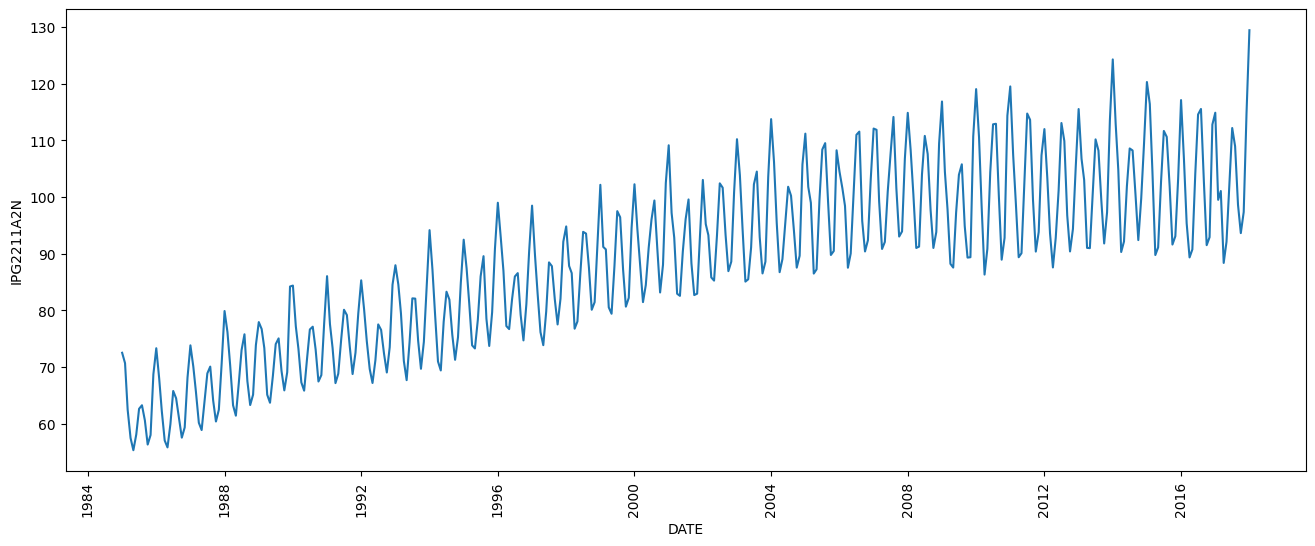

In [ ]:
# visualizing the series
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x="DATE", y="IPG2211A2N")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# taking the log for the series to minimize variance
df["IPG2211A2N"] = np.log(df["IPG2211A2N"])

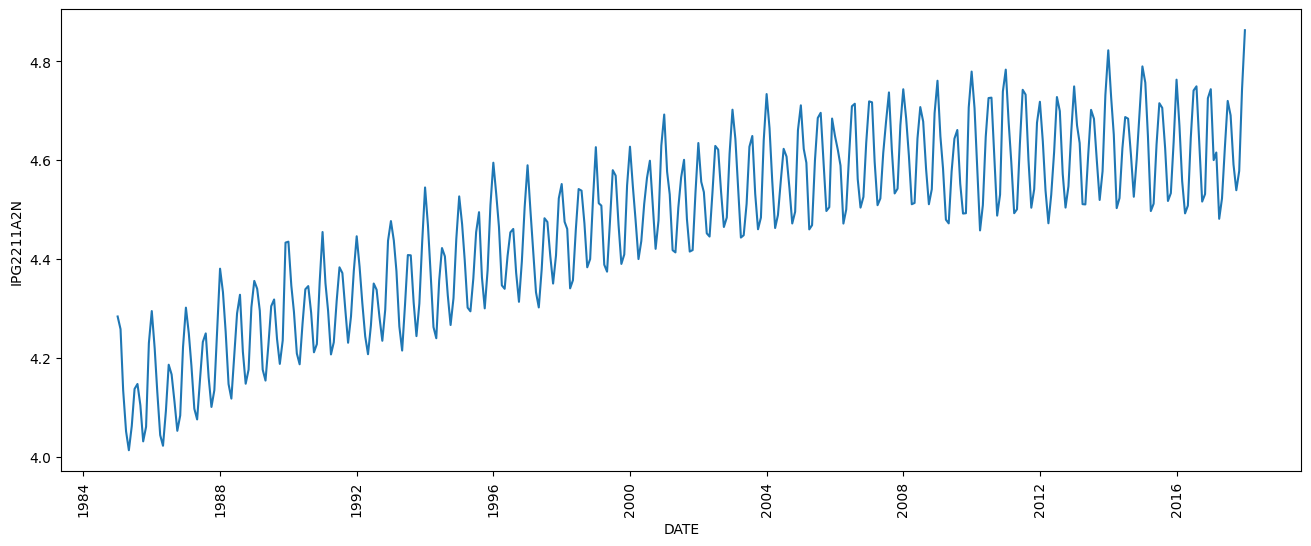

In [ ]:
# visualizing the series
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x="DATE", y="IPG2211A2N")
plt.xticks(rotation=90)
plt.show()

<Figure size 1200x600 with 0 Axes>

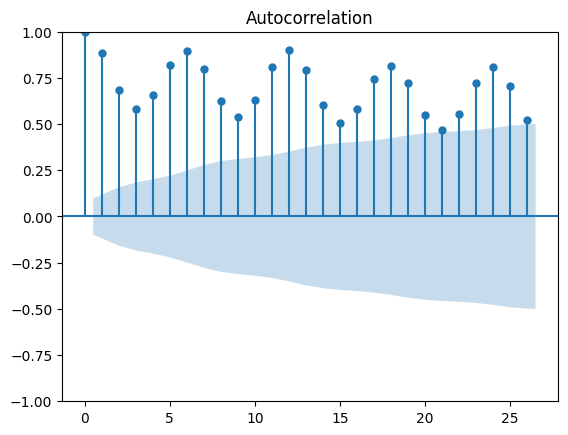

In [ ]:
plt.figure(figsize=(12,6))
plot_acf(df["IPG2211A2N"])
plt.show()


<Figure size 1200x600 with 0 Axes>

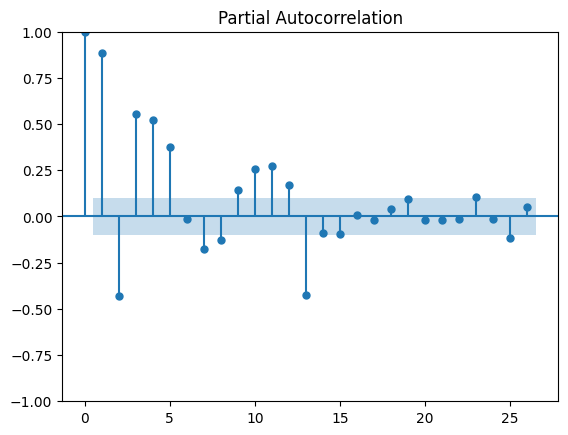

In [ ]:
plt.figure(figsize=(12,6))
plot_pacf(df["IPG2211A2N"])
plt.show()

<Figure size 640x480 with 0 Axes>

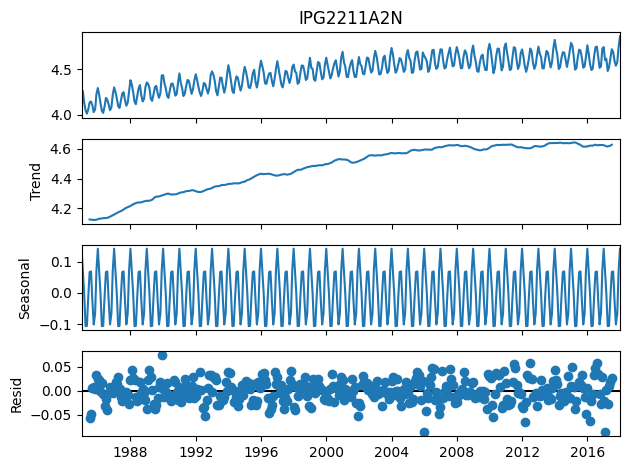

In [ ]:
decompose = seasonal_decompose(df["IPG2211A2N"], model='additive', period=12)

plt.figure()
decompose.plot()
plt.show()

In [ ]:
result = adfuller(df["IPG2211A2N"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.14536042810772
p-value: 0.02337340103298579


## preprocessing and modeling the data

In [ ]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]["IPG2211A2N"]
test = df.iloc[train_size:]["IPG2211A2N"]

In [ ]:
model = SARIMAX(train,
                order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           IPG2211A2N   No. Observations:                  317
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 651.666
Date:                              Thu, 29 May 2025   AIC                          -1297.333
Time:                                      20:30:46   BIC                          -1286.303
Sample:                                  01-01-1985   HQIC                         -1292.915
                                       - 05-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9491      0.020     47.432      0.000       0.910       0.988
ma.S.L12      -0.77

In [ ]:
residuals = results.resid

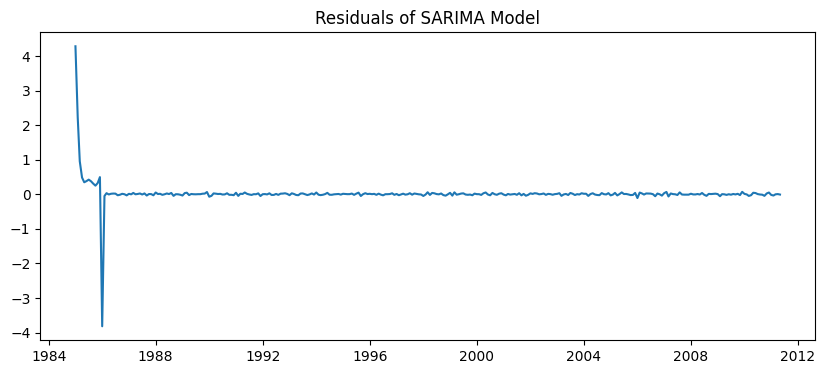

In [ ]:
# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.show()

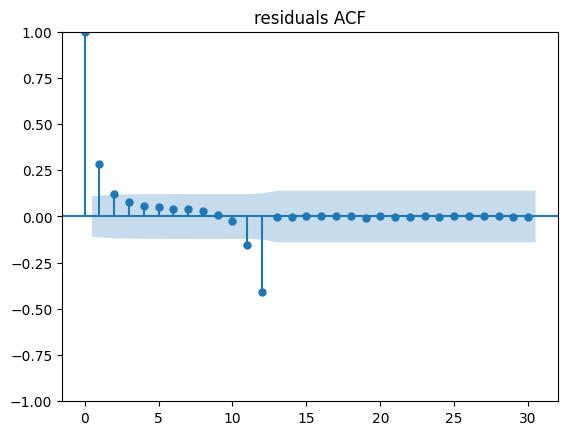

In [ ]:
plot_acf(residuals, lags=30)
plt.title("residuals ACF")
plt.show()

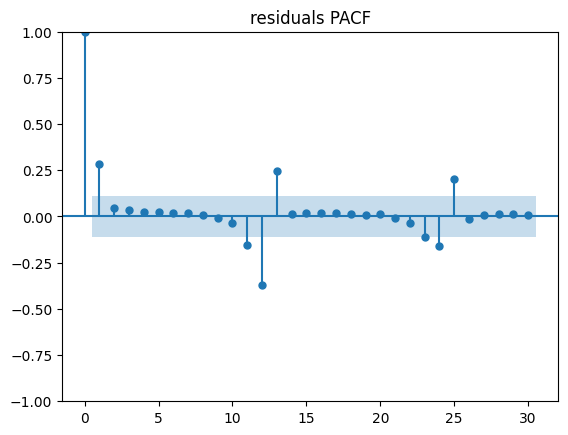

In [ ]:
plot_pacf(residuals, lags=30)
plt.title("residuals PACF")
plt.show()

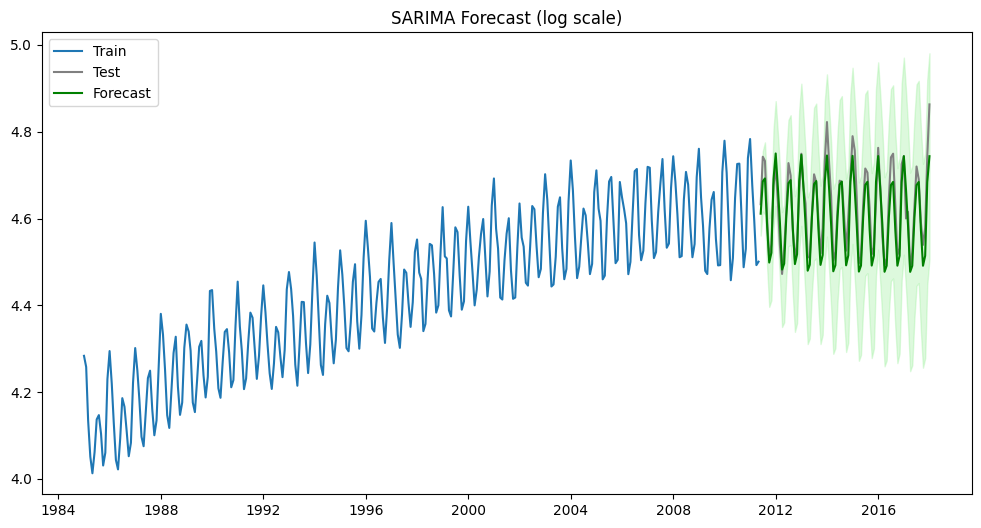

In [ ]:
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='gray')
plt.plot(test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.3)
plt.title("SARIMA Forecast (log scale)")
plt.legend()
plt.show()

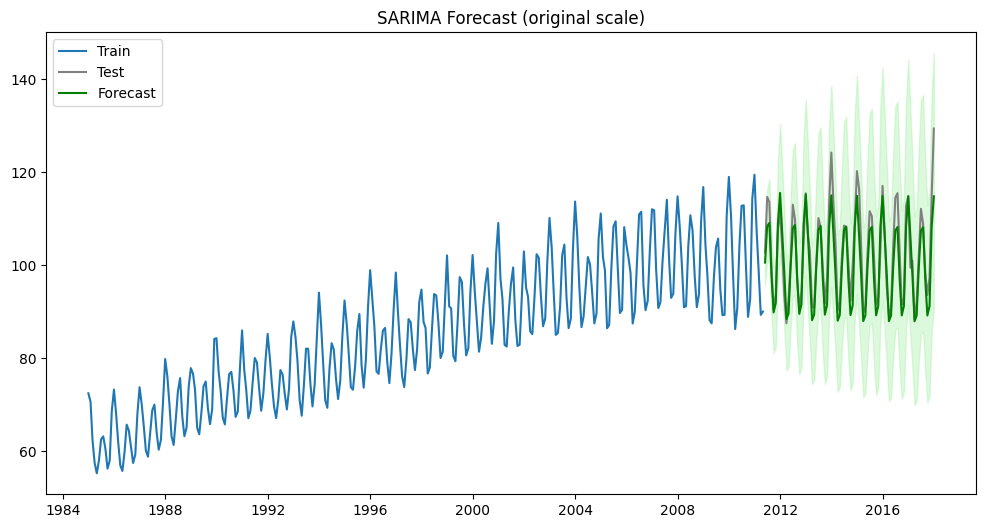

In [ ]:
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, np.exp(train), label='Train')
plt.plot(test.index, np.exp(test), label='Test', color='gray')
plt.plot(test.index, np.exp(forecast_mean), label='Forecast', color='green')
plt.fill_between(test.index, np.exp(conf_int).iloc[:, 0], np.exp(conf_int).iloc[:, 1],
                 color='lightgreen', alpha=0.3)
plt.title("SARIMA Forecast (original scale)")
plt.legend()
plt.show()